# March Machine Learning Mania
In this notebook, we perform __EDA__ on the provided data via this [Kaggle competition](https://www.kaggle.com/competitions/march-machine-learning-mania-2024/overview) using the detailed statistics. With the compact stats, we had access to 38 men's seasons and 25 women's seasons. Using the detailed stats, this is reduced to 20 men's and 13 women's, reducing are data to almost 50% of it's original size.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# display 100 rows and 100 columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# global random seed
SEED = 9

## Load Data

In [2]:
# root dirs
root = 'data/'
mroot = 'data/mens/'
wroot = 'data/womens/'

# reg season DETAILED results
regresults = pd.concat([pd.read_csv(mroot + 'MRegularSeasonDetailedResults.csv'), pd.read_csv(wroot + 'WRegularSeasonDetailedResults.csv')], ignore_index=True)

# historical tourney results
m_results = pd.read_csv(mroot + 'MNCAATourneyCompactResults.csv')
m_results = m_results.drop(m_results[m_results['Season'] < 2003].index)
w_results = pd.read_csv(wroot + 'WNCAATourneyCompactResults.csv')
w_results = w_results.drop(w_results[w_results['Season'] < 2010].index)
results = pd.concat([m_results, w_results]).reset_index(drop=True)
del m_results, w_results

# historical seeds
m_seeds = pd.read_csv(mroot + 'MNCAATourneySeeds.csv')
m_seeds = m_seeds.drop(m_seeds[m_seeds['Season'] < 2003].index)
w_seeds = pd.read_csv(wroot + 'WNCAATourneySeeds.csv')
w_seeds = w_seeds.drop(w_seeds[w_seeds['Season'] < 2010].index)
seeds =  pd.concat([m_seeds, w_seeds]).reset_index(drop=True)
del m_seeds, w_seeds

## Feature Creation

In [3]:
# compute score differential
regresults['ScoreDiff'] = regresults['WScore'] - regresults['LScore']

In [4]:
# some groups we will be using
win_group = regresults.groupby(['Season', 'WTeamID'])
lose_group = regresults.groupby(['Season', 'LTeamID'])

### Win Ratio

In [5]:
# get wins and losses for every team in every season
num_wins = win_group.count().reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={'DayNum': 'num_wins', 'WTeamID': 'TeamID'})
num_losses = lose_group.count().reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={'DayNum': 'num_losses', 'LTeamID': 'TeamID'})

# merge wins and losses, fill nulls, cast to int, drop tables
win_loss = num_wins.merge(num_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
win_loss = win_loss.astype({'num_wins': int, 'num_losses': int})
del num_wins, num_losses

# add games played
win_loss['num_games'] = win_loss['num_wins'] + win_loss['num_losses']

# add ratio
win_loss['win_ratio'] = win_loss['num_wins'] / win_loss['num_games']

# check
print(win_loss.shape)
win_loss.head()

(12857, 6)


,Season,TeamID,num_wins,num_losses,num_games,win_ratio
0,2003,1102,12,16,28,0.428571
1,2003,1103,13,14,27,0.481481
2,2003,1104,17,11,28,0.607143
3,2003,1105,7,19,26,0.269231
4,2003,1106,13,15,28,0.464286


In [6]:
# 14 undefeated seasons
win_loss.loc[win_loss['num_losses'] == 0].shape

(14, 6)

In [7]:
# 29 winless seasons
win_loss.loc[win_loss['num_wins'] == 0].shape

(29, 6)

### Score Differential, Aggregate Statistics from Reg Season

In [8]:
# get score diff features for both wins and losses for each team
win_gaps = win_group['ScoreDiff'].agg(['sum', 'var']).reset_index() \
.rename(columns={'WTeamID': 'TeamID', 'sum': 'sum_win_diff', 'var': 'var_win_diff'})
loss_gaps = lose_group['ScoreDiff'].agg(['sum', 'var']).reset_index() \
.rename(columns={'LTeamID': 'TeamID', 'sum': 'sum_loss_diff', 'var': 'var_loss_diff'})

# make loss diffs negative
loss_gaps['sum_loss_diff'] = -loss_gaps['sum_loss_diff']

# merge the 2 tables
pts = win_gaps.merge(loss_gaps, on=['Season', 'TeamID'], how='outer')
del win_gaps, loss_gaps

# cols we will be aggregating
agg_cols = ['Score', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']

# for the stats above, get sum, mean, var for wins and losses, then append to pts df
for col in agg_cols:
    # get winning/losing col name
    wcol = 'W' + col
    lcol = 'L' + col

    # get stats for wins and losses
    x_for_win = win_group[wcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'WTeamID': 'TeamID', 'sum': f'sum_{col}_for_win', 'mean': f'mean_{col}_for_win', 'var': f'var_{col}_for_win'})
    x_against_win = win_group[lcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'WTeamID': 'TeamID', 'sum': f'sum_{col}_against_win', 'mean': f'mean_{col}_against_win', 'var': f'var_{col}_against_win'})
    x_for_loss = lose_group[lcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'LTeamID': 'TeamID', 'sum': f'sum_{col}_for_loss', 'mean': f'mean_{col}_for_loss', 'var': f'var_{col}_for_loss'})
    x_against_loss = lose_group[wcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'LTeamID': 'TeamID', 'sum': f'sum_{col}_against_loss', 'mean': f'mean_{col}_against_loss', 'var': f'var_{col}_against_loss'})

    # merge to pts
    pts = pts.merge(x_for_win, on=['Season', 'TeamID'], how='outer')
    pts = pts.merge(x_against_win, on=['Season', 'TeamID'], how='outer')
    pts = pts.merge(x_for_loss, on=['Season', 'TeamID'], how='outer')
    pts = pts.merge(x_against_loss, on=['Season', 'TeamID'], how='outer')


# fill nulls, drop vars
pts = pts.fillna(0)
del x_for_win, x_against_win, x_for_loss, x_against_loss

# typecase all cols that start with 'sum' to int
for col in pts.columns:
    if col.startswith('sum'):
        pts[col] = pts[col].astype(int)

# create 'merged' df by merging pts with win_loss
merged = pts.merge(win_loss, on=['Season', 'TeamID'], how='outer')
del win_loss, pts

# get aggregate stats
for col in agg_cols:
    # calculate average/std of stats for/against per game
    new_cols = {f'avg_{col}_for': (merged[f'sum_{col}_for_win'] + merged[f'sum_{col}_for_loss']) / merged['num_games'],
    f'avg_{col}_against': (merged[f'sum_{col}_against_win'] + merged[f'sum_{col}_against_loss']) / merged['num_games'],
    f'std_{col}_for': np.sqrt(((merged[f'var_{col}_for_win'] * merged['num_wins']) + (merged[f'var_{col}_for_loss'] * merged['num_losses'])) / merged['num_games']),
    f'std_{col}_against': np.sqrt(((merged[f'var_{col}_against_win'] * merged['num_wins']) + (merged[f'var_{col}_against_loss'] * merged['num_losses'])) / merged['num_games'])}

    # add to merged
    merged = pd.concat([merged, pd.DataFrame(new_cols)], axis=1)

# copy to reduce fragmentation
merged = merged.copy()

# calculate average score diff per game
merged['avg_diff'] = merged['avg_Score_for'] - merged['avg_Score_against']

# calculate std score diff per game
merged['std_diff'] = np.sqrt(((merged['var_win_diff'] * merged['num_wins']) + (merged['var_loss_diff'] * merged['num_losses']) + \
                            (merged['num_wins'] * (((merged['sum_win_diff'] / merged['num_wins']) - merged['avg_diff'])**2)) + \
                            (merged['num_losses'] * (((merged['sum_loss_diff'] / merged['num_losses']) - merged['avg_diff'])**2))) / \
                            merged['num_games'])

# drop cols that start with 'sum', 'mean', and 'var'
for col in merged.columns:
    if col.startswith('sum') or col.startswith('mean') or col.startswith('var'):
        merged = merged.drop(col, axis=1)

# drop num_wins and num_losses
merged = merged.drop(columns=['num_wins', 'num_losses'])

# check
merged.head()

,Season,TeamID,num_games,win_ratio,avg_Score_for,avg_Score_against,std_Score_for,std_Score_against,avg_FGM_for,avg_FGM_against,std_FGM_for,std_FGM_against,avg_FGA_for,avg_FGA_against,std_FGA_for,std_FGA_against,avg_FGM3_for,avg_FGM3_against,std_FGM3_for,std_FGM3_against,avg_FGA3_for,avg_FGA3_against,std_FGA3_for,std_FGA3_against,avg_FTM_for,avg_FTM_against,std_FTM_for,std_FTM_against,avg_FTA_for,avg_FTA_against,std_FTA_for,std_FTA_against,avg_OR_for,avg_OR_against,std_OR_for,std_OR_against,avg_DR_for,avg_DR_against,std_DR_for,std_DR_against,avg_Ast_for,avg_Ast_against,std_Ast_for,std_Ast_against,avg_TO_for,avg_TO_against,std_TO_for,std_TO_against,avg_Stl_for,avg_Stl_against,std_Stl_for,std_Stl_against,avg_Blk_for,avg_Blk_against,std_Blk_for,std_Blk_against,avg_PF_for,avg_PF_against,std_PF_for,std_PF_against,avg_diff,std_diff
0,2003,1102,28,0.428571,57.250000,57.000000,9.675884,12.006203,19.142857,19.285714,3.251440,4.403265,39.785714,42.428571,5.174446,5.402741,7.821429,4.750000,3.712766,2.870548,20.821429,12.428571,6.273096,5.036662,11.142857,13.678571,5.635885,4.838361,17.107143,19.250000,7.204391,6.178180,4.178571,9.607143,2.262101,3.161217,16.821429,20.142857,5.056499,5.193069,13.000000,9.142857,3.469409,3.189539,11.428571,12.964286,4.324149,3.158202,5.964286,5.428571,2.400803,2.972092,1.785714,1.571429,1.547236,1.749335,18.750000,18.357143,3.020457,3.882082,0.250000,16.069930
1,2003,1103,27,0.481481,78.777778,78.148148,12.701351,13.039060,27.148148,27.777778,4.312574,5.425398,55.851852,57.000000,7.831136,7.931808,5.444444,6.666667,2.776495,2.385657,16.074074,18.370370,5.683526,4.969565,19.037037,15.925926,8.248543,6.914997,25.851852,22.148148,11.183334,10.272498,9.777778,12.037037,3.454562,4.772458,19.925926,22.037037,5.107858,5.004319,15.222222,15.481481,2.811082,4.474577,12.629630,15.333333,3.532444,4.274974,7.259259,6.407407,3.841902,2.371984,2.333333,2.851852,1.649340,1.932994,19.851852,22.444444,6.177918,5.421984,0.629630,11.317278
2,2003,1104,28,0.607143,69.285714,65.000000,9.239231,7.619172,24.035714,23.250000,4.519205,2.535815,57.178571,55.500000,6.610598,5.370804,6.357143,6.357143,1.990379,2.786126,19.857143,19.142857,3.756661,5.506084,14.857143,12.142857,5.077172,4.905172,20.928571,17.142857,6.167093,6.623821,13.571429,10.892857,3.698455,3.217835,23.928571,22.642857,3.899519,3.188428,12.107143,11.678571,2.504995,3.654254,13.285714,13.857143,3.430431,3.351039,6.607143,5.535714,2.563306,2.183133,3.785714,3.178571,1.956445,2.353569,18.035714,19.250000,3.608398,3.110466,4.285714,13.293146
3,2003,1105,26,0.269231,71.769231,76.653846,12.432725,12.703052,24.384615,27.000000,4.753766,6.167533,61.615385,58.961538,7.093093,9.283981,7.576923,6.269231,3.015629,2.708013,20.769231,17.538462,5.811865,4.143783,15.423077,16.384615,6.270948,5.887841,21.846154,24.500000,8.373493,8.096375,13.500000,13.192308,3.631533,4.618802,23.115385,26.384615,4.730787,4.196050,14.538462,15.807692,4.174096,4.155112,18.653846,18.807692,4.952337,4.389673,9.307692,9.384615,4.014929,3.328843,2.076923,4.192308,1.255756,2.765786,20.230769,19.076923,4.095025,4.337769,-4.884615,15.878579
4,2003,1106,28,0.464286,63.607143,63.750000,10.705552,11.594004,23.428571,21.714286,4.332777,4.376032,55.285714,53.392857,6.607432,7.490243,6.107143,4.785714,2.241575,2.968800,17.642857,15.214286,3.630113,6.600286,10.642857,15.535714,5.626634,5.035757,16.464286,21.964286,6.437362,6.695643,12.285714,11.321429,5.335273,4.241438,23.857143,22.357143,4.354605,4.658581,11.678571,11.785714,4.083108,3.771537,17.035714,15.071429,4.281943,3.533008,8.357143,8.785714,2.927700,3.693279,3.142857,3.178571,2.018200,2.179059,18.178571,16.142857,2.563314,4.070698,-0.142857,12.550428


### Home/Away/Neutral Location Win ratio

In [9]:
# get H/A/N wins for each team
home_wins = regresults.loc[regresults['WLoc'] == 'H'].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'home_wins', 'WTeamID': 'TeamID'})
away_wins = regresults.loc[regresults['WLoc'] == 'A'].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'away_wins', 'WTeamID': 'TeamID'})
neutral_wins = regresults.loc[regresults['WLoc'] == 'N'].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'neutral_wins', 'WTeamID': 'TeamID'})

# get H/A/N losses for each team
home_losses = regresults.loc[regresults['WLoc'] == 'A'].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'home_losses', 'LTeamID': 'TeamID'})
away_losses = regresults.loc[regresults['WLoc'] == 'H'].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'away_losses', 'LTeamID': 'TeamID'})
neutral_losses = regresults.loc[regresults['WLoc'] == 'N'].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'neutral_losses', 'LTeamID': 'TeamID'})

# combine, fill nulls, typecast, drop tables
merged = merged.merge(home_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(away_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(neutral_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(home_losses, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(away_losses, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(neutral_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
merged = merged.astype({'home_wins': int, 'away_wins': int, 'neutral_wins': int, 'home_losses': int, 'away_losses': int, 'neutral_losses': int})
del home_wins, away_wins, neutral_wins, home_losses, away_losses, neutral_losses

# calculate win ratios for H/A/N games
merged['home_games'] = merged['home_wins'] + merged['home_losses']
merged['away_games'] = merged['away_wins'] + merged['away_losses']
merged['neutral_games'] = merged['neutral_wins'] + merged['neutral_losses']
merged['home_win_ratio'] = merged['home_wins'] / merged['home_games']
merged['away_win_ratio'] = merged['away_wins'] / merged['away_games']
merged['neutral_win_ratio'] = merged['neutral_wins'] / merged['neutral_games']
merged = merged.fillna(0)

# add missing indicators
merged['home_missing'] = (merged['home_games'] == 0).astype(int)
merged['away_missing'] = (merged['away_games'] == 0).astype(int)
merged['neutral_missing'] = (merged['neutral_games'] == 0).astype(int)

# drop old cols
merged = merged.drop(columns=['home_games', 'away_games', 'neutral_games', 'home_wins', 'away_wins', 'neutral_wins', 'home_losses', 'away_losses', 'neutral_losses'])

# check
merged.head()

,Season,TeamID,num_games,win_ratio,avg_Score_for,avg_Score_against,std_Score_for,std_Score_against,avg_FGM_for,avg_FGM_against,std_FGM_for,std_FGM_against,avg_FGA_for,avg_FGA_against,std_FGA_for,std_FGA_against,avg_FGM3_for,avg_FGM3_against,std_FGM3_for,std_FGM3_against,avg_FGA3_for,avg_FGA3_against,std_FGA3_for,std_FGA3_against,avg_FTM_for,avg_FTM_against,std_FTM_for,std_FTM_against,avg_FTA_for,avg_FTA_against,std_FTA_for,std_FTA_against,avg_OR_for,avg_OR_against,std_OR_for,std_OR_against,avg_DR_for,avg_DR_against,std_DR_for,std_DR_against,avg_Ast_for,avg_Ast_against,std_Ast_for,std_Ast_against,avg_TO_for,avg_TO_against,std_TO_for,std_TO_against,avg_Stl_for,avg_Stl_against,std_Stl_for,std_Stl_against,avg_Blk_for,avg_Blk_against,std_Blk_for,std_Blk_against,avg_PF_for,avg_PF_against,std_PF_for,std_PF_against,avg_diff,std_diff,home_win_ratio,away_win_ratio,neutral_win_ratio,home_missing,away_missing,neutral_missing
0,2003,1102,28,0.428571,57.250000,57.000000,9.675884,12.006203,19.142857,19.285714,3.251440,4.403265,39.785714,42.428571,5.174446,5.402741,7.821429,4.750000,3.712766,2.870548,20.821429,12.428571,6.273096,5.036662,11.142857,13.678571,5.635885,4.838361,17.107143,19.250000,7.204391,6.178180,4.178571,9.607143,2.262101,3.161217,16.821429,20.142857,5.056499,5.193069,13.000000,9.142857,3.469409,3.189539,11.428571,12.964286,4.324149,3.158202,5.964286,5.428571,2.400803,2.972092,1.785714,1.571429,1.547236,1.749335,18.750000,18.357143,3.020457,3.882082,0.250000,16.069930,0.692308,0.230769,0.00,0,0,0
1,2003,1103,27,0.481481,78.777778,78.148148,12.701351,13.039060,27.148148,27.777778,4.312574,5.425398,55.851852,57.000000,7.831136,7.931808,5.444444,6.666667,2.776495,2.385657,16.074074,18.370370,5.683526,4.969565,19.037037,15.925926,8.248543,6.914997,25.851852,22.148148,11.183334,10.272498,9.777778,12.037037,3.454562,4.772458,19.925926,22.037037,5.107858,5.004319,15.222222,15.481481,2.811082,4.474577,12.629630,15.333333,3.532444,4.274974,7.259259,6.407407,3.841902,2.371984,2.333333,2.851852,1.649340,1.932994,19.851852,22.444444,6.177918,5.421984,0.629630,11.317278,0.642857,0.307692,0.00,0,0,1
2,2003,1104,28,0.607143,69.285714,65.000000,9.239231,7.619172,24.035714,23.250000,4.519205,2.535815,57.178571,55.500000,6.610598,5.370804,6.357143,6.357143,1.990379,2.786126,19.857143,19.142857,3.756661,5.506084,14.857143,12.142857,5.077172,4.905172,20.928571,17.142857,6.167093,6.623821,13.571429,10.892857,3.698455,3.217835,23.928571,22.642857,3.899519,3.188428,12.107143,11.678571,2.504995,3.654254,13.285714,13.857143,3.430431,3.351039,6.607143,5.535714,2.563306,2.183133,3.785714,3.178571,1.956445,2.353569,18.035714,19.250000,3.608398,3.110466,4.285714,13.293146,0.866667,0.111111,0.75,0,0,0
3,2003,1105,26,0.269231,71.769231,76.653846,12.432725,12.703052,24.384615,27.000000,4.753766,6.167533,61.615385,58.961538,7.093093,9.283981,7.576923,6.269231,3.015629,2.708013,20.769231,17.538462,5.811865,4.143783,15.423077,16.384615,6.270948,5.887841,21.846154,24.500000,8.373493,8.096375,13.500000,13.192308,3.631533,4.618802,23.115385,26.384615,4.730787,4.196050,14.538462,15.807692,4.174096,4.155112,18.653846,18.807692,4.952337,4.389673,9.307692,9.384615,4.014929,3.328843,2.076923,4.192308,1.255756,2.765786,20.230769,19.076923,4.095025,4.337769,-4.884615,15.878579,0.416667,0.142857,0.00,0,0,1
4,2003,1106,28,0.464286,63.607143,63.750000,10.705552,11.594004,23.428571,21.714286,4.332777,4.376032,55.285714,53.392857,6.607432,7.490243,6.107143,4.785714,2.241575,2.968800,17.642857,15.214286,3.630113,6.600286,10.642857,15.535714,5.626634,5.035757,16.464286,21.964286,6.437362,6.695643,12.285714,11.321429,5.335273,4.241438,23.857143,22.357143,4.354605,4.658581,11.678571,11.785714,4.083108,3.771537,17.035714,15.071429,4.281943,3.533008,8.357143,8.785714,2.927700,3.693279,3.142857,3.178571,2.018200,2.179059,18.178571,16.142857,2.563314,4.070698,-0.142857,12.550428,0.666667,0.357143,0.00,0,0,0


### 1-Score and OT Game Win Ratios

In [10]:
# get all rows for each team where they won/lost by 3 points or less
close_wins = regresults.loc[regresults['ScoreDiff'] <= 3].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: '1_score_wins', 'WTeamID': 'TeamID'})
close_losses = regresults.loc[regresults['ScoreDiff'] >= 3].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: '1_score_losses', 'LTeamID': 'TeamID'})

# get num of games where NumOT > 0
ot_wins = regresults.loc[regresults['NumOT'] > 0].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'ot_wins', 'WTeamID': 'TeamID'})
ot_losses = regresults.loc[regresults['NumOT'] > 0].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'ot_losses', 'LTeamID': 'TeamID'})

# merge, fill nulls, typecast, drop tables
merged = merged.merge(close_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(close_losses, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(ot_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(ot_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
merged = merged.astype({'1_score_wins': int, '1_score_losses': int, 'ot_wins': int, 'ot_losses': int})
del close_wins, close_losses, ot_wins, ot_losses

# add missing indicator columns
merged['1_score_game_missing'] = np.where(((merged['1_score_wins'] == 0) & (merged['1_score_losses'] == 0)), 1, 0)
merged['ot_game_missing'] = np.where(((merged['ot_wins'] == 0) & (merged['ot_losses'] == 0)), 1, 0)

# calculate close and ot ratios
merged['1_score_game_ratio'] = (merged['1_score_wins'] + merged['1_score_losses']) / merged['num_games']
merged['1_score_win_ratio'] = merged['1_score_wins'] / (merged['1_score_wins'] + merged['1_score_losses'])
merged['ot_ratio'] = (merged['ot_wins'] + merged['ot_losses']) / merged['num_games']
merged['ot_win_ratio'] = merged['ot_wins'] / (merged['ot_wins'] + merged['ot_losses'])

# fill nulls for teams that never played in close or ot games
merged = merged.fillna(0)

# drop old cols
merged = merged.drop(columns=['1_score_wins', '1_score_losses', 'ot_wins', 'ot_losses'])

# check
merged.head()

,Season,TeamID,num_games,win_ratio,avg_Score_for,avg_Score_against,std_Score_for,std_Score_against,avg_FGM_for,avg_FGM_against,std_FGM_for,std_FGM_against,avg_FGA_for,avg_FGA_against,std_FGA_for,std_FGA_against,avg_FGM3_for,avg_FGM3_against,std_FGM3_for,std_FGM3_against,avg_FGA3_for,avg_FGA3_against,std_FGA3_for,std_FGA3_against,avg_FTM_for,avg_FTM_against,std_FTM_for,std_FTM_against,avg_FTA_for,avg_FTA_against,std_FTA_for,std_FTA_against,avg_OR_for,avg_OR_against,std_OR_for,std_OR_against,avg_DR_for,avg_DR_against,std_DR_for,std_DR_against,avg_Ast_for,avg_Ast_against,std_Ast_for,std_Ast_against,avg_TO_for,avg_TO_against,std_TO_for,std_TO_against,avg_Stl_for,avg_Stl_against,std_Stl_for,std_Stl_against,avg_Blk_for,avg_Blk_against,std_Blk_for,std_Blk_against,avg_PF_for,avg_PF_against,std_PF_for,std_PF_against,avg_diff,std_diff,home_win_ratio,away_win_ratio,neutral_win_ratio,home_missing,away_missing,neutral_missing,1_score_game_missing,ot_game_missing,1_score_game_ratio,1_score_win_ratio,ot_ratio,ot_win_ratio
0,2003,1102,28,0.428571,57.250000,57.000000,9.675884,12.006203,19.142857,19.285714,3.251440,4.403265,39.785714,42.428571,5.174446,5.402741,7.821429,4.750000,3.712766,2.870548,20.821429,12.428571,6.273096,5.036662,11.142857,13.678571,5.635885,4.838361,17.107143,19.250000,7.204391,6.178180,4.178571,9.607143,2.262101,3.161217,16.821429,20.142857,5.056499,5.193069,13.000000,9.142857,3.469409,3.189539,11.428571,12.964286,4.324149,3.158202,5.964286,5.428571,2.400803,2.972092,1.785714,1.571429,1.547236,1.749335,18.750000,18.357143,3.020457,3.882082,0.250000,16.069930,0.692308,0.230769,0.00,0,0,0,0,1,0.500000,0.000000,0.000000,0.00
1,2003,1103,27,0.481481,78.777778,78.148148,12.701351,13.039060,27.148148,27.777778,4.312574,5.425398,55.851852,57.000000,7.831136,7.931808,5.444444,6.666667,2.776495,2.385657,16.074074,18.370370,5.683526,4.969565,19.037037,15.925926,8.248543,6.914997,25.851852,22.148148,11.183334,10.272498,9.777778,12.037037,3.454562,4.772458,19.925926,22.037037,5.107858,5.004319,15.222222,15.481481,2.811082,4.474577,12.629630,15.333333,3.532444,4.274974,7.259259,6.407407,3.841902,2.371984,2.333333,2.851852,1.649340,1.932994,19.851852,22.444444,6.177918,5.421984,0.629630,11.317278,0.642857,0.307692,0.00,0,0,1,0,0,0.555556,0.266667,0.148148,0.75
2,2003,1104,28,0.607143,69.285714,65.000000,9.239231,7.619172,24.035714,23.250000,4.519205,2.535815,57.178571,55.500000,6.610598,5.370804,6.357143,6.357143,1.990379,2.786126,19.857143,19.142857,3.756661,5.506084,14.857143,12.142857,5.077172,4.905172,20.928571,17.142857,6.167093,6.623821,13.571429,10.892857,3.698455,3.217835,23.928571,22.642857,3.899519,3.188428,12.107143,11.678571,2.504995,3.654254,13.285714,13.857143,3.430431,3.351039,6.607143,5.535714,2.563306,2.183133,3.785714,3.178571,1.956445,2.353569,18.035714,19.250000,3.608398,3.110466,4.285714,13.293146,0.866667,0.111111,0.75,0,0,0,0,0,0.321429,0.000000,0.035714,1.00
3,2003,1105,26,0.269231,71.769231,76.653846,12.432725,12.703052,24.384615,27.000000,4.753766,6.167533,61.615385,58.961538,7.093093,9.283981,7.576923,6.269231,3.015629,2.708013,20.769231,17.538462,5.811865,4.143783,15.423077,16.384615,6.270948,5.887841,21.846154,24.500000,8.373493,8.096375,13.500000,13.192308,3.631533,4.618802,23.115385,26.384615,4.730787,4.196050,14.538462,15.807692,4.174096,4.155112,18.653846,18.807692,4.952337,4.389673,9.307692,9.384615,4.014929,3.328843,2.076923,4.192308,1.255756,2.765786,20.230769,19.076923,4.095025,4.337769,-4.884615,15.878579,0.416667,0.142857,0.00,0,0,1,0,0,0.538462,0.071429,0.115385,0.00
4,2003,1106,28,0.464286,63.607143,63.750000,10.705552,11.594004,23.428571,21.714286,4.332777,4.376032,55.285714,53.392857,6.607432,7.490243,6.107143,4.785714,2.241575,2.968800,17.642857,15.214286,3.630113,6.600286,10.642857,15.535714,5.626634,5.035757,16.464286,21.964286,6.437362,6.695643,12.285714,11.321429,5.335273,4.241438,23.857143,22.357143,4.354605,4.658581,11.678571,11.785714,4.083108,3.771537,17.035714,15.071429,4.281943,3.53

### Performance in Last 3 Games (Conference Tournament)

In [11]:
# conference tourneys are last 1-3 games of reg season
RECENT_GAMES = 3

# get last RECENT_GAMES wins and last RECENT_GAMES losses of each team (to assess recent form going into tourney)
recent_wins = win_group.tail(RECENT_GAMES).reset_index(drop=True)
recent_losses = lose_group.tail(RECENT_GAMES).reset_index(drop=True)

# add TeamID col to identify the rows pertaining to each team
recent_wins['TeamID'] = recent_wins['WTeamID']
recent_losses['TeamID'] = recent_losses['LTeamID']

# order by DayNum, get last RECENT_GAMES games
combined = pd.concat([recent_wins, recent_losses], ignore_index=True).sort_values(by=['Season', 'TeamID', 'DayNum']).reset_index(drop=True)
last_recent_games = combined.groupby(['Season', 'TeamID']).tail(RECENT_GAMES).reset_index(drop=True)
del recent_wins, recent_losses, combined

# create ScoreDiff col
last_recent_games['ScoreDiff'] = last_recent_games['WScore'] - last_recent_games['LScore']

# check first 4 rows
last_recent_games.head(RECENT_GAMES + 1)[['TeamID']]

,TeamID
0,1102
1,1102
2,1102
3,1103


Now we have the last RECENT_GAMES games for each team grouped together in the last_recent_games dataframe.

In [12]:
# look at teams who don't have a final RECENT_GAMES games
last_recent_games.groupby(['Season', 'TeamID']).size().reset_index().rename(columns={0: 'num_games'}).sort_values(by='num_games', ascending=True).head()

,Season,TeamID,num_games
10694,2021,3469,2
0,2003,1102,3
8565,2018,3427,3
8566,2018,3428,3
8567,2018,3429,3


In [13]:
# look at the team with only 2 games
seeds[(seeds['Season'] == 2021) & (seeds['TeamID'] == 3469)]

,Season,Seed,TeamID


- There was 1 team in 2021 who did not even have RECENT_GAMES games played, but they didn't make the tournament anyway.

In [14]:
# groups for recent games
recent_win_group = last_recent_games.loc[last_recent_games['WTeamID'] == last_recent_games['TeamID']].groupby(['Season', 'TeamID'])
recent_loss_group = last_recent_games.loc[last_recent_games['LTeamID'] == last_recent_games['TeamID']].groupby(['Season', 'TeamID'])

# sum and var of score differential for wins and losses
score_diff_win = recent_win_group['ScoreDiff'].agg(['sum']).reset_index().rename(columns={'sum': 'recent_sum_win_diff'})
score_diff_loss = recent_win_group['ScoreDiff'].agg(['sum']).reset_index().rename(columns={'sum': 'recent_sum_loss_diff'})

# make loss diffs negative
score_diff_loss['recent_sum_loss_diff'] = -score_diff_loss['recent_sum_loss_diff']

# merge, fill nulls, drop tables
recent = score_diff_win.merge(score_diff_loss, on=['Season', 'TeamID'], how='outer')
recent = recent.fillna(0)
del score_diff_win, score_diff_loss

# merge wins and losses for each team -> outer merge because some teams have no wins or losses in the last RECENT_GAMES games
recent = recent.merge(recent_win_group.size().reset_index().rename(columns={0: 'recent_wins', 'WTeamID': 'TeamID'}), on=['Season', 'TeamID'], how='outer')
recent = recent.merge(recent_loss_group.size().reset_index().rename(columns={0: 'recent_losses', 'LTeamID': 'TeamID'}), on=['Season', 'TeamID'], how='outer').fillna(0)
recent = recent.astype({'recent_wins': int, 'recent_losses': int})

# calculate win ratio for last RECENT_GAMES games
recent['recent_win_ratio'] = recent['recent_wins'] / RECENT_GAMES

# calculate sum/var of stats for and against in wins and losses
for col in agg_cols:
    # get winning/losing col name
    wcol = 'W' + col
    lcol = 'L' + col

    # get stats for wins and losses
    recent_x_for_win = recent_win_group[wcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'WTeamID': 'TeamID', 'sum': f'recent_sum_{col}_for_win', 'mean': f'recent_mean_{col}_for_win', 'var': f'recent_var_{col}_for_win'})
    recent_x_against_win = recent_win_group[lcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'WTeamID': 'TeamID', 'sum': f'recent_sum_{col}_against_win', 'mean': f'recent_mean_{col}_against_win', 'var': f'recent_var_{col}_against_win'})
    recent_x_for_loss = recent_loss_group[lcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'LTeamID': 'TeamID', 'sum': f'recent_sum_{col}_for_loss', 'mean': f'recent_mean_{col}_for_loss', 'var': f'recent_var_{col}_for_loss'})
    recent_x_against_loss = recent_loss_group[wcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'LTeamID': 'TeamID', 'sum': f'recent_sum_{col}_against_loss', 'mean': f'recent_mean_{col}_against_loss', 'var': f'recent_var_{col}_against_loss'})

    # merge to recent df
    recent = recent.merge(recent_x_for_win, on=['Season', 'TeamID'], how='outer')
    recent = recent.merge(recent_x_against_win, on=['Season', 'TeamID'], how='outer')
    recent = recent.merge(recent_x_for_loss, on=['Season', 'TeamID'], how='outer')
    recent = recent.merge(recent_x_against_loss, on=['Season', 'TeamID'], how='outer')

# fill nulls, drop vars
recent = recent.fillna(0)
del recent_x_for_win, recent_x_against_win, recent_x_for_loss, recent_x_against_loss

# typecase all cols that contain 'sum' to int
for col in recent.columns:
    if 'sum' in col:
        recent[col] = recent[col].astype(int)

# get aggregate stats
for col in agg_cols:
    # calculate average/std of stats for/against per game
    new_cols = {f'recent_avg_{col}_for': (recent[f'recent_sum_{col}_for_win'] + recent[f'recent_sum_{col}_for_loss']) / RECENT_GAMES,
    f'recent_avg_{col}_against': (recent[f'recent_sum_{col}_against_win'] + recent[f'recent_sum_{col}_against_loss']) / RECENT_GAMES,
    f'recent_std_{col}_for': np.sqrt((recent[f'recent_var_{col}_for_win'] * recent['recent_wins']) + (recent[f'recent_var_{col}_for_loss'] * recent['recent_losses'])) / RECENT_GAMES,
    f'recent_std_{col}_against': np.sqrt((recent[f'recent_var_{col}_against_win'] * recent['recent_wins']) + (recent[f'recent_var_{col}_against_loss'] * recent['recent_losses'])) / RECENT_GAMES}

    # add to recent
    recent = pd.concat([recent, pd.DataFrame(new_cols)], axis=1)

# copy to reduce fragmentation
recent = recent.copy()

# calculate average score diff per game
recent['recent_avg_diff'] = recent['recent_avg_Score_for'] - recent['recent_avg_Score_against']

# drop cols that start with 'sum', 'mean', and 'var'
for col in recent.columns:
    if col.startswith('recent_sum') or col.startswith('recent_mean') or col.startswith('recent_var'):
        recent = recent.drop(col, axis=1)

# drop recent_wins and recent_losses
recent = recent.drop(columns=['recent_wins', 'recent_losses'])

# get the teams that won their last game (conference champions)
last_game = last_recent_games.groupby(['Season', 'TeamID']).tail(1).reset_index(drop=True)
last_game_win = last_game[last_game['TeamID'] == last_game['WTeamID']][['Season', 'TeamID']]
last_game_win['conf_champs'] = 1
last_game_win['conf_champs'] = last_game_win['conf_champs'].astype(int)

# merge
recent = recent.merge(last_game_win, on=['Season', 'TeamID'], how='outer').fillna(0)
del last_game, last_game_win, last_recent_games

# check
recent.head()

,Season,TeamID,recent_win_ratio,recent_avg_Score_for,recent_avg_Score_against,recent_std_Score_for,recent_std_Score_against,recent_avg_FGM_for,recent_avg_FGM_against,recent_std_FGM_for,recent_std_FGM_against,recent_avg_FGA_for,recent_avg_FGA_against,recent_std_FGA_for,recent_std_FGA_against,recent_avg_FGM3_for,recent_avg_FGM3_against,recent_std_FGM3_for,recent_std_FGM3_against,recent_avg_FGA3_for,recent_avg_FGA3_against,recent_std_FGA3_for,recent_std_FGA3_against,recent_avg_FTM_for,recent_avg_FTM_against,recent_std_FTM_for,recent_std_FTM_against,recent_avg_FTA_for,recent_avg_FTA_against,recent_std_FTA_for,recent_std_FTA_against,recent_avg_OR_for,recent_avg_OR_against,recent_std_OR_for,recent_std_OR_against,recent_avg_DR_for,recent_avg_DR_against,recent_std_DR_for,recent_std_DR_against,recent_avg_Ast_for,recent_avg_Ast_against,recent_std_Ast_for,recent_std_Ast_against,recent_avg_TO_for,recent_avg_TO_against,recent_std_TO_for,recent_std_TO_against,recent_avg_Stl_for,recent_avg_Stl_against,recent_std_Stl_for,recent_std_Stl_against,recent_avg_Blk_for,recent_avg_Blk_against,recent_std_Blk_for,recent_std_Blk_against,recent_avg_PF_for,recent_avg_PF_against,recent_std_PF_for,recent_std_PF_against,recent_avg_diff,conf_champs
0,2003,1102,0.333333,52.666667,53.000000,4.666667,5.000000,18.333333,17.666667,1.666667,2.000000,38.333333,40.333333,2.666667,0.333333,3.000000,4.666667,0.333333,0.000000,12.666667,12.333333,2.333333,0.333333,13.000000,13.000000,1.666667,1.000000,17.666667,18.666667,3.000000,2.000000,3.333333,7.666667,2.000000,0.000000,19.000000,20.000000,4.333333,1.333333,8.333333,8.333333,1.666667,0.000000,9.333333,11.000000,0.333333,2.333333,6.333333,4.000000,1.666667,0.000000,1.000000,1.333333,0.333333,1.333333,18.666667,17.666667,0.666667,0.666667,-0.333333,0.0
1,2003,1103,0.333333,74.000000,73.333333,3.666667,3.000000,26.000000,28.333333,1.666667,1.666667,54.666667,56.000000,1.333333,0.333333,7.333333,6.000000,1.333333,0.000000,23.000000,19.666667,1.000000,1.666667,14.666667,10.666667,1.000000,0.333333,19.000000,15.000000,1.000000,2.000000,9.666667,11.000000,0.666667,0.000000,19.000000,19.000000,3.666667,0.333333,16.666667,19.333333,0.666667,0.333333,13.333333,15.333333,2.333333,0.333333,7.666667,6.666667,2.000000,0.666667,3.000000,1.333333,0.333333,0.333333,15.333333,18.666667,0.333333,0.000000,0.666667,0.0
2,2003,1104,0.333333,71.000000,69.000000,2.333333,5.333333,25.333333,25.000000,0.333333,0.666667,59.666667,53.000000,0.333333,2.000000,8.000000,7.333333,1.000000,0.333333,20.333333,22.666667,0.333333,0.333333,12.333333,11.666667,0.666667,6.333333,17.000000,17.000000,0.666667,6.666667,13.666667,7.000000,0.666667,0.666667,23.666667,22.333333,1.000000,0.666667,10.333333,12.333333,0.000000,0.666667,13.666667,12.000000,1.000000,2.000000,7.666667,8.000000,2.333333,0.666667,2.333333,5.000000,1.666667,1.333333,17.000000,16.333333,3.000000,1.666667,2.000000,0.0
3,2003,1106,0.333333,60.666667,63.666667,1.666667,4.000000,22.666667,22.333333,1.000000,0.666667,52.666667,49.333333,1.333333,1.333333,4.666667,4.000000,1.000000,0.333333,17.000000,14.333333,1.000000,3.000000,10.666667,15.000000,1.333333,2.333333,18.333333,20.666667,0.333333,0.666667,10.333333,10.333333,2.333333,1.000000,20.333333,24.666667,1.666667,4.000000,8.000000,10.666667,1.333333,2.333333,15.000000,15.333333,1.333333,1.333333,7.333333,5.666667,1.333333,0.666667,1.333333,2.666667,0.666667,0.000000,18.000000,16.666667,0.333333,2.000000,-3.000000,0.0
4,2003,1108,0.666667,65.666667,65.333333,4.333333,3.000000,22.333333,22.666667,0.666667,1.000000,57.333333,54.000000,1.000000,3.000000,4.333333,4.333333,0.333333,0.333333,18.666667,16.333333,1.333333,1.333333,16.666667,15.666667,2.666667,0.666667,23.000000,25.333333,3.333333,4.666667,11.666667,14.000000,2.333333,0.000000,23.333333,27.000000,4.000000,3.666667,12.000000,14.333333,1.333333,0.000000,12.000000,14.000000,0.666667,2.666667,6.333333,4.666667,1.000000,0.666667,4.000000,2.333333,1.333333,0.333333,21.666667,20.000000,1

In [15]:
# merge 2 final tables
merged = merged.merge(recent, on=['Season', 'TeamID'], how='outer').sort_values(['Season', 'TeamID'])
del recent

# check
print(merged.shape)
merged.head()

(12857, 133)


,Season,TeamID,num_games,win_ratio,avg_Score_for,avg_Score_against,std_Score_for,std_Score_against,avg_FGM_for,avg_FGM_against,std_FGM_for,std_FGM_against,avg_FGA_for,avg_FGA_against,std_FGA_for,std_FGA_against,avg_FGM3_for,avg_FGM3_against,std_FGM3_for,std_FGM3_against,avg_FGA3_for,avg_FGA3_against,std_FGA3_for,std_FGA3_against,avg_FTM_for,avg_FTM_against,std_FTM_for,std_FTM_against,avg_FTA_for,avg_FTA_against,std_FTA_for,std_FTA_against,avg_OR_for,avg_OR_against,std_OR_for,std_OR_against,avg_DR_for,avg_DR_against,std_DR_for,std_DR_against,avg_Ast_for,avg_Ast_against,std_Ast_for,std_Ast_against,avg_TO_for,avg_TO_against,std_TO_for,std_TO_against,avg_Stl_for,avg_Stl_against,...,recent_avg_FGA_for,recent_avg_FGA_against,recent_std_FGA_for,recent_std_FGA_against,recent_avg_FGM3_for,recent_avg_FGM3_against,recent_std_FGM3_for,recent_std_FGM3_against,recent_avg_FGA3_for,recent_avg_FGA3_against,recent_std_FGA3_for,recent_std_FGA3_against,recent_avg_FTM_for,recent_avg_FTM_against,recent_std_FTM_for,recent_std_FTM_against,recent_avg_FTA_for,recent_avg_FTA_against,recent_std_FTA_for,recent_std_FTA_against,recent_avg_OR_for,recent_avg_OR_against,recent_std_OR_for,recent_std_OR_against,recent_avg_DR_for,recent_avg_DR_against,recent_std_DR_for,recent_std_DR_against,recent_avg_Ast_for,recent_avg_Ast_against,recent_std_Ast_for,recent_std_Ast_against,recent_avg_TO_for,recent_avg_TO_against,recent_std_TO_for,recent_std_TO_against,recent_avg_Stl_for,recent_avg_Stl_against,recent_std_Stl_for,recent_std_Stl_against,recent_avg_Blk_for,recent_avg_Blk_against,recent_std_Blk_for,recent_std_Blk_against,recent_avg_PF_for,recent_avg_PF_against,recent_std_PF_for,recent_std_PF_against,recent_avg_diff,conf_champs
0,2003,1102,28,0.428571,57.250000,57.000000,9.675884,12.006203,19.142857,19.285714,3.251440,4.403265,39.785714,42.428571,5.174446,5.402741,7.821429,4.750000,3.712766,2.870548,20.821429,12.428571,6.273096,5.036662,11.142857,13.678571,5.635885,4.838361,17.107143,19.250000,7.204391,6.178180,4.178571,9.607143,2.262101,3.161217,16.821429,20.142857,5.056499,5.193069,13.000000,9.142857,3.469409,3.189539,11.428571,12.964286,4.324149,3.158202,5.964286,5.428571,...,38.333333,40.333333,2.666667,0.333333,3.000000,4.666667,0.333333,0.000000,12.666667,12.333333,2.333333,0.333333,13.000000,13.000000,1.666667,1.000000,17.666667,18.666667,3.000000,2.000000,3.333333,7.666667,2.000000,0.000000,19.000000,20.000000,4.333333,1.333333,8.333333,8.333333,1.666667,0.000000,9.333333,11.000000,0.333333,2.333333,6.333333,4.000000,1.666667,0.000000,1.000000,1.333333,0.333333,1.333333,18.666667,17.666667,0.666667,0.666667,-0.333333,0.0
1,2003,1103,27,0.481481,78.777778,78.148148,12.701351,13.039060,27.148148,27.777778,4.312574,5.425398,55.851852,57.000000,7.831136,7.931808,5.444444,6.666667,2.776495,2.385657,16.074074,18.370370,5.683526,4.969565,19.037037,15.925926,8.248543,6.914997,25.851852,22.148148,11.183334,10.272498,9.777778,12.037037,3.454562,4.772458,19.925926,22.037037,5.107858,5.004319,15.222222,15.481481,2.811082,4.474577,12.629630,15.333333,3.532444,4.274974,7.259259,6.407407,...,54.666667,56.000000,1.333333,0.333333,7.333333,6.000000,1.333333,0.000000,23.000000,19.666667,1.000000,1.666667,14.666667,10.666667,1.000000,0.333333,19.000000,15.000000,1.000000,2.000000,9.666667,11.000000,0.666667,0.000000,19.000000,19.000000,3.666667,0.333333,16.666667,19.333333,0.666667,0.333333,13.333333,15.333333,2.333333,0.333333,7.666667,6.666667,2.000000,0.666667,3.000000,1.333333,0.333333,0.333333,15.333333,18.666667,0.333333,0.000000,0.666667,0.0
2,2003,1104,28,0.607143,69.285714,65.000000,9.239231,7.619172,24.035714,23.250000,4.519205,2.535815,57.178571,55.500000,6.610598,5.370804,6.357143,6.357143,1.990379,2.786126,19.857143,19.142857,3.756661,5.506084,14.857143,12.142857,5.077172,4.905172,20.928571,17.142857,6.167093,6.623821,13.571429,10.892857,3.698455,3.217835,23.928571,22.642857,3.899519,3.188428,12.107143,11.678571,2.504995,3.654254,13.285714,13.857143,3.430431,3.351039

In __merged__, each row is a single NCAA team's entire regular season (including conference tournaments) containing DETAILED aggregated data. We have access to almost 13k NCAA basketball seasons. Keep in mind, only 64 teams make the tournament each year, so most of the rows in this dataframe will not be part of the follwing merge.

### Seed

In [16]:
# merge tourney results with historical seed data
df = pd.merge(results, seeds, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).rename(columns={'Seed': 'WSeed'}).drop(columns='TeamID')
df = pd.merge(df, seeds, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).rename(columns={'Seed': 'LSeed'}).drop(columns='TeamID')
del results

# seperate region from seed
df['WRegionSeed'] = df['WSeed'].apply(lambda x: x[:3])
df['LRegionSeed'] = df['LSeed'].apply(lambda x: x[:3])
df['WRegion'] = df['WSeed'].apply(lambda x: x[0])
df['LRegion'] = df['LSeed'].apply(lambda x: x[0])

# drop region from seed
df['WSeed'] = df['WSeed'].apply(lambda x: x[1:])
df['LSeed'] = df['LSeed'].apply(lambda x: x[1:])

# add play-in col for winning and losing teams
df['WPlayIn'] = df['WSeed'].apply(lambda x: 1 if len(x) > 2 else 0)
df['LPlayIn'] = df['LSeed'].apply(lambda x: 1 if len(x) > 2 else 0)

# drop letter and convert to int
df['WSeed'] = df['WSeed'].apply(lambda x: int(x[:2]))
df['LSeed'] = df['LSeed'].apply(lambda x: int(x[:2]))

# check
print(df.shape)
df.head()

(2142, 16)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,WRegionSeed,LRegionSeed,WRegion,LRegion,WPlayIn,LPlayIn
0,2003,134,1421,92,1411,84,N,1,16,16,X16,X16,X,X,1,1
1,2003,136,1112,80,1436,51,N,0,1,16,Z01,Z16,Z,Z,0,0
2,2003,136,1113,84,1272,71,N,0,10,7,Z10,Z07,Z,Z,0,0
3,2003,136,1141,79,1166,73,N,0,11,6,Z11,Z06,Z,Z,0,0
4,2003,136,1143,76,1301,74,N,1,8,9,W08,W09,W,W,0,0


In __df__, each row is a NCAA Tournament game. We have access to over 2k games, which will effectively act as our labels.

In [17]:
# merge df with merged for winning and losing teams
df = pd.merge(df, merged, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop(columns='TeamID')
df = df.rename(columns={x: 'W' + x for x in merged.columns[2:]})
df = pd.merge(df, merged, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop(columns='TeamID')
df = df.rename(columns={x: 'L' + x for x in merged.columns[2:]})

# check
print(df.shape)
df.head()

(2142, 278)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,WRegionSeed,LRegionSeed,WRegion,LRegion,WPlayIn,LPlayIn,Wnum_games,Wwin_ratio,Wavg_Score_for,Wavg_Score_against,Wstd_Score_for,Wstd_Score_against,Wavg_FGM_for,Wavg_FGM_against,Wstd_FGM_for,Wstd_FGM_against,Wavg_FGA_for,Wavg_FGA_against,Wstd_FGA_for,Wstd_FGA_against,Wavg_FGM3_for,Wavg_FGM3_against,Wstd_FGM3_for,Wstd_FGM3_against,Wavg_FGA3_for,Wavg_FGA3_against,Wstd_FGA3_for,Wstd_FGA3_against,Wavg_FTM_for,Wavg_FTM_against,Wstd_FTM_for,Wstd_FTM_against,Wavg_FTA_for,Wavg_FTA_against,Wstd_FTA_for,Wstd_FTA_against,Wavg_OR_for,Wavg_OR_against,Wstd_OR_for,Wstd_OR_against,...,Lrecent_avg_FGA_for,Lrecent_avg_FGA_against,Lrecent_std_FGA_for,Lrecent_std_FGA_against,Lrecent_avg_FGM3_for,Lrecent_avg_FGM3_against,Lrecent_std_FGM3_for,Lrecent_std_FGM3_against,Lrecent_avg_FGA3_for,Lrecent_avg_FGA3_against,Lrecent_std_FGA3_for,Lrecent_std_FGA3_against,Lrecent_avg_FTM_for,Lrecent_avg_FTM_against,Lrecent_std_FTM_for,Lrecent_std_FTM_against,Lrecent_avg_FTA_for,Lrecent_avg_FTA_against,Lrecent_std_FTA_for,Lrecent_std_FTA_against,Lrecent_avg_OR_for,Lrecent_avg_OR_against,Lrecent_std_OR_for,Lrecent_std_OR_against,Lrecent_avg_DR_for,Lrecent_avg_DR_against,Lrecent_std_DR_for,Lrecent_std_DR_against,Lrecent_avg_Ast_for,Lrecent_avg_Ast_against,Lrecent_std_Ast_for,Lrecent_std_Ast_against,Lrecent_avg_TO_for,Lrecent_avg_TO_against,Lrecent_std_TO_for,Lrecent_std_TO_against,Lrecent_avg_Stl_for,Lrecent_avg_Stl_against,Lrecent_std_Stl_for,Lrecent_std_Stl_against,Lrecent_avg_Blk_for,Lrecent_avg_Blk_against,Lrecent_std_Blk_for,Lrecent_std_Blk_against,Lrecent_avg_PF_for,Lrecent_avg_PF_against,Lrecent_std_PF_for,Lrecent_std_PF_against,Lrecent_avg_diff,Lconf_champs
0,2003,134,1421,92,1411,84,N,1,16,16,X16,X16,X,X,1,1,29,0.448276,71.206897,78.448276,8.942216,12.333069,24.379310,27.793103,3.212941,6.243525,56.793103,60.965517,7.481010,6.888354,6.482759,7.620690,2.199530,2.623720,18.000000,20.758621,3.940360,4.518926,15.965517,15.241379,7.169780,5.690282,20.931034,22.551724,8.849703,7.886188,12.275862,13.724138,3.797458,3.472718,...,51.666667,65.666667,2.403701,5.925463,4.666667,7.000000,1.201850,2.081666,13.000000,25.666667,0.577350,5.897269,19.333333,14.333333,2.027588,5.666667,30.333333,21.000000,2.603417,8.888194,12.333333,14.333333,1.201850,1.452966,29.666667,23.666667,0.881917,1.452966,15.000000,13.666667,3.055050,2.728451,13.666667,10.000000,1.855921,1.154701,4.000000,8.666667,1.154701,1.763834,3.333333,3.333333,1.333333,0.333333,18.000000,22.333333,4.725816,2.185813,4.000000,1.0
1,2003,136,1112,80,1436,51,N,0,1,16,Z01,Z16,Z,Z,0,0,28,0.892857,85.214286,70.250000,10.222087,8.945104,30.321429,26.357143,3.937382,3.540581,65.714286,64.678571,7.236646,6.186583,7.035714,6.321429,2.645189,2.688711,20.071429,19.964286,4.474797,5.694086,17.535714,11.214286,5.015749,5.349677,25.000000,17.714286,6.257614,6.401265,15.178571,13.107143,3.362078,4.064949,...,49.666667,52.333333,4.176655,4.055175,4.666667,6.666667,0.881917,1.855921,13.000000,20.333333,2.081666,0.333333,14.000000,10.666667,4.582576,1.666667,21.000000,16.333333,4.618802,3.382964,11.000000,9.333333,2.309401,2.333333,25.333333,17.333333,2.905933,2.603417,15.333333,10.333333,5.364492,2.185813,13.000000,11.333333,2.309401,2.027588,7.000000,6.000000,2.081666,1.732051,2.000000,3.000000,0.577350,0.577350,15.333333,17.000000,2.603417,2.645751,12.000000,1.0
2,2003,136,1113,84,1272,71,N,0,10,7,Z10,Z07,Z,Z,0,0,29,0.620690,75.965517,69.172414,10.407596,10.385999,27.206897,24.793103,4.048990,3.805782,56.896552,55.655172,6.357918,6.849172,4.000000,5.448276,1.517845,2.314694,12.586207,15.896552,3.423164,4.582664,17.551724,14.137931,5.735198,4.704406,26.206897,20.517241,8.940370,6.429616,13.689655,11.000000,4.950465,3.869106,...,51.666667,58.333333,0.666667,1.333333,8.333333,4.333333,0.666667,2.000000,20.666667,18.000000,1.666667,2.666667,21.333333,18.666667,0.000000,1.000000,31.666667,31.666667,0.333333,0.333333,11.666667,16.000000,4.333333,0.333333,25.000000,22.

### 2024 Data

In [ ]:
# get features for 2024 data, merge with seeds
df_2024 = merged.loc[merged['Season'] == 2024]
df_2024 = pd.merge(df_2024, seeds.loc[seeds['Season'] == 2024], how='left', left_on='TeamID', right_on='TeamID')
del merged, seeds

# drop null seeds (team that didn't make tourney)
df_2024 = df_2024.dropna(subset=['Seed'])

# rename Season_x, drop Season_y
df_2024 = df_2024.rename(columns={'Season_x': 'Season'}).drop(columns='Season_y')

# seperate region and seed
df_2024['RegionSeed'] = df_2024['Seed']
df_2024['Region'] = df_2024['Seed'].apply(lambda x: x[0])
df_2024['Seed'] = df_2024['Seed'].apply(lambda x: x[1:])
df_2024['PlayIn'] = df_2024['Seed'].apply(lambda x: 1 if len(str(x)) > 2 else 0)
df_2024['Seed'] = df_2024['Seed'].apply(lambda x: int(x[:2]))

# check
print(df_2024.shape)
df_2024.head()

In [135]:
# save 2024 data
df_2024.to_csv('data/processed/2024_features_detailed.csv', index=False)

### Game Location

In [129]:
# look at men's game locations (with respect to winning team)
df[df['WTeamID'] < 3000]['WLoc'].value_counts()

N    1315
Name: WLoc, dtype: int64

All men's games since 2003 have been played at a neutral site.

In [130]:
# women's game locations
df[df['WTeamID'] >= 3000]['WLoc'].value_counts()

N    525
H    258
A     44
Name: WLoc, dtype: int64

Most women's games since 2010 have been played at a neutral site, however the winning team does play at home much more often than the losing team.

## Upsets
- In this section, we look at the number of upsets (underdog winning) in past NCAA brackets. 
- In this competition, we are only predicting the 63 bracket games, not the 4 play-in games. Due to this, we can drop the 4 losing play-in teams from our seeds table, leaving 64 teams.

In [18]:
# create seed diff col
df['Wseed_diff'] = df['LSeed'] - df['WSeed']

# check
df[['WSeed', 'LSeed', 'Wseed_diff']].head()

,WSeed,LSeed,Wseed_diff
0,16,16,0
1,1,16,15
2,10,7,-3
3,11,6,-5
4,8,9,1


In [19]:
# split mens and womens data
df_mens = df[df['WTeamID'] < 3000].copy().reset_index(drop=True)
df_womens = df[df['WTeamID'] >= 3000].copy().reset_index(drop=True)

# shapes
print(df_mens.shape)
print(df_womens.shape)

(1315, 279)
(827, 279)


Over 1300 men's tournament games.

Over 800 women's tournament games.

In [20]:
# assign round to 0 for all rows (play-in games will remain as round 0)
df_mens['round'] = 0

# drop play-in games
play_in_indices = df_mens.loc[(df_mens['WPlayIn'] == 1) & (df_mens['LPlayIn'] == 1)].index
df_no_play_ins = df_mens.drop(index=play_in_indices)

# group by season
for season, group in df_no_play_ins.groupby('Season'):
    # order by daynum to assign rounds
    group = group.sort_values(by='DayNum')

    if season != 2021:
        df_mens.loc[group.index[:32], 'round'] = 1
        df_mens.loc[group.index[32:48], 'round'] = 2
        df_mens.loc[group.index[48:56], 'round'] = 3
        df_mens.loc[group.index[56:60], 'round'] = 4
        df_mens.loc[group.index[60:62], 'round'] = 5
        df_mens.loc[group.index[62], 'round'] = 6

    # there was a 1st round game between VCU and Oregon in 2021 that was cancelled
    else:
        df_mens.loc[group.index[:31], 'round'] = 1
        df_mens.loc[group.index[31:47], 'round'] = 2
        df_mens.loc[group.index[47:55], 'round'] = 3
        df_mens.loc[group.index[55:59], 'round'] = 4
        df_mens.loc[group.index[59:61], 'round'] = 5
        df_mens.loc[group.index[61], 'round'] = 6

# check
df_mens['round'].value_counts()   

1    639
2    320
3    160
4     80
0     56
5     40
6     20
Name: round, dtype: int64

In [21]:
# assign round to 0 for all rows (play-in games will remain as round 0)
df_womens['round'] = 0

# drop play-in games
play_in_indices = df_womens.loc[(df_womens['WPlayIn'] == 1) & (df_womens['LPlayIn'] == 1)].index
df_no_play_ins = df_womens.drop(index=play_in_indices)

# group by season
for season, group in df_no_play_ins.groupby('Season'):
    # order by daynum to assign rounds
    group = group.sort_values(by='DayNum')

    df_womens.loc[group.index[:32], 'round'] = 1
    df_womens.loc[group.index[32:48], 'round'] = 2
    df_womens.loc[group.index[48:56], 'round'] = 3
    df_womens.loc[group.index[56:60], 'round'] = 4
    df_womens.loc[group.index[60:62], 'round'] = 5
    df_womens.loc[group.index[62], 'round'] = 6

# check
df_womens['round'].value_counts()      

1    416
2    208
3    104
4     52
5     26
6     13
0      8
Name: round, dtype: int64

In [22]:
# drop play-in games for bracket analysis
df_mens = df_mens.drop(index=df_mens.loc[(df_mens['round'] == 0)].index).reset_index(drop=True)
df_womens = df_womens.drop(index=df_womens.loc[(df_womens['round'] == 0)].index).reset_index(drop=True)

### Men's Upsets

In [23]:
# get favorite wins (lower/better seed wins), get upsets (higher/worse seed wins), and equal seed wins
mfavorites = df_mens.loc[df_mens['Wseed_diff'] > 0][['Season', 'WTeamID', 'LTeamID', 'WRegionSeed', 'LRegionSeed', 'Wseed_diff', 'round']]
mupsets = df_mens.loc[df_mens['Wseed_diff'] < 0][['Season', 'WTeamID', 'LTeamID', 'WRegionSeed', 'LRegionSeed', 'Wseed_diff', 'round']]
mequals = df_mens.loc[df_mens['Wseed_diff'] == 0][['Season', 'WTeamID', 'LTeamID', 'WRegionSeed', 'LRegionSeed', 'Wseed_diff', 'round']]

print('MEN\'S BRACKET:\n')
print(f'% of games where better seed won: {mfavorites.shape[0] / df_mens.shape[0] * 100: .2f}%, ({mfavorites.shape[0]}/{df_mens.shape[0]})')
print(f'% of games where worse seed won: {mupsets.shape[0] / df_mens.shape[0] * 100: .2f}%, ({mupsets.shape[0]}/{df_mens.shape[0]})')
print(f'% of games where seeds are equal: {mequals.shape[0] / df_mens.shape[0] * 100: .2f}%, ({mequals.shape[0]}/{df_mens.shape[0]})')

MEN'S BRACKET:

% of games where better seed won:  70.14%, (883/1259)
% of games where worse seed won:  28.75%, (362/1259)
% of games where seeds are equal:  1.11%, (14/1259)


- We can see that the better seed wins the majority of the time (70%).
- Very few bracket games occur between equal seeds (1%), as this can only happen in the final four and championship games.

C:\Users\heefj\AppData\Local\Temp\ipykernel_18028\1808879143.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])


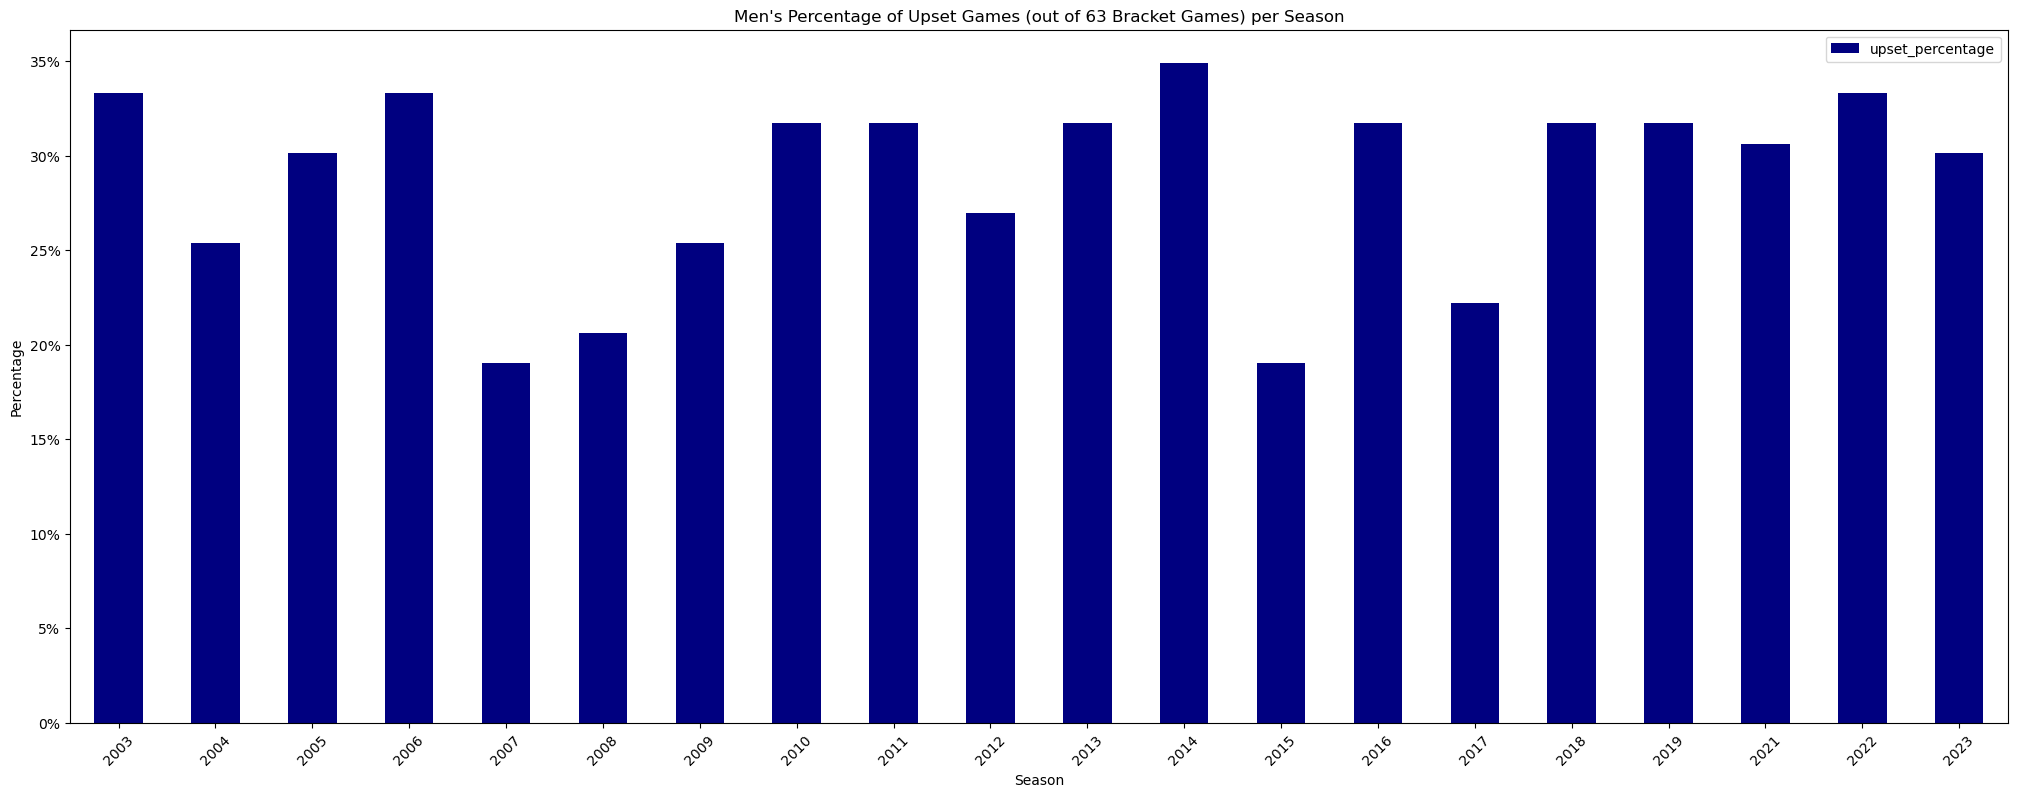

In [24]:
# plot men's percentage of upsets per season
mupset_percentage = (mupsets.groupby('Season').count() / df_mens.groupby('Season').count()).rename(columns={'LRegionSeed': 'upset_percentage'}) \
    .reset_index()[['Season', 'upset_percentage']]
ax = mupset_percentage.plot(kind='bar', figsize=(25, 9), x='Season',y='upset_percentage', title='Men\'s Percentage of Upset Games (out of 63 Bracket Games) per Season', 
                            ylabel='Percentage', xlabel='Season', color='navy', rot=45)
ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])
plt.show()

In [25]:
# men's
mupset_percentage[['upset_percentage']].describe().T

,count,mean,std,min,25%,50%,75%,max
upset_percentage,20.0,0.287545,0.050516,0.190476,0.253968,0.311956,0.31746,0.349206


#### Round-by-Round Upsets in Men's Bracket

In [26]:
print('MEN\'S BRACKET:\n')

# look at upset % per round
for round in list(range(1,7)):
    print(f'Round {round} Upset %: {mupsets[mupsets["round"] == round].shape[0] / df_mens[df_mens["round"] == round].shape[0] * 100:.1f}% \
          ({mupsets[mupsets["round"] == round].shape[0]}/{df_mens[df_mens["round"] == round].shape[0]}) games \
          Avg Seed Diff: {mupsets[mupsets["round"] == round]["Wseed_diff"].mean():.2f}')

MEN'S BRACKET:

Round 1 Upset %: 26.4%           (169/639) games           Avg Seed Diff: -5.25
Round 2 Upset %: 28.7%           (92/320) games           Avg Seed Diff: -5.14
Round 3 Upset %: 31.2%           (50/160) games           Avg Seed Diff: -3.38
Round 4 Upset %: 50.0%           (40/80) games           Avg Seed Diff: -2.98
Round 5 Upset %: 20.0%           (8/40) games           Avg Seed Diff: -3.00
Round 6 Upset %: 15.0%           (3/20) games           Avg Seed Diff: -1.00


In [27]:
# stack WSeed and LSeed into a single column
np.mean(df_mens['WSeed'].to_list() + df_mens['LSeed'].to_list())

6.7434471803018265

In [28]:
# create df to hold historical upset data
mupsets_df = pd.DataFrame(columns=['Season', 'Round', 'Pct_upsets', 'Avg_seed_diff', 'Std_seed_diff', 'Avg_seed', 'Std_seed'])

# get upset data for each season and round
for season, group in df_mens.groupby('Season'):
    for round in list(range(1,7)):
        round_group = group[group['round'] == round]

        pct_upsets = group[(group['round'] == round) & (group['Wseed_diff'] < 0)].shape[0] / round_group.shape[0]
        avg_seed_diff = group[(group['round'] == round) & (group['Wseed_diff'] < 0)]['Wseed_diff'].mean()
        std_seed_diff = group[(group['round'] == round) & (group['Wseed_diff'] < 0)]['Wseed_diff'].std()

        # add col for average seed of the teams in that round
        avg_seed = np.mean(round_group['WSeed'].to_list() + round_group['LSeed'].to_list())
        std_seed = np.std(round_group['WSeed'].to_list() + round_group['LSeed'].to_list())

        mupsets_df = pd.concat([mupsets_df, pd.DataFrame([[season, round, pct_upsets, avg_seed_diff, std_seed_diff, avg_seed, std_seed]], columns=mupsets_df.columns)], ignore_index=True)

# fill nulls, check
mupsets_df = mupsets_df.fillna(0)
mupsets_df['Tournament'] = 'M'
mupsets_df.head(6)

,Season,Round,Pct_upsets,Avg_seed_diff,Std_seed_diff,Avg_seed,Std_seed,Tournament
0,2003,1,0.250,-3.750000,3.011881,8.5000,4.609772,M
1,2003,2,0.375,-4.333333,3.204164,5.4375,3.445445,M
2,2003,3,0.250,-1.000000,0.000000,4.1875,3.186274,M
3,2003,4,0.750,-1.666667,0.577350,2.3750,1.932453,M
4,2003,5,0.500,-2.000000,0.000000,2.2500,0.829156,M
5,2003,6,1.000,-1.000000,0.000000,2.5000,0.500000,M


In [29]:
# get abs value of seed diff so we can group
df_mens['abs_seed_diff'] = df_mens['Wseed_diff'].abs()

# print win % of each underdog seed diff group
for seed_diff in sorted(df_mens['abs_seed_diff'].unique())[1:]:
    print(f'-{seed_diff} seed diff win %: {df_mens.loc[(df_mens["abs_seed_diff"] == seed_diff) & (df_mens["Wseed_diff"] < 0)].shape[0] / df_mens.loc[df_mens["abs_seed_diff"] == seed_diff].shape[0] * 100:.1f}% \
            ({df_mens.loc[(df_mens["abs_seed_diff"] == seed_diff) & (df_mens["Wseed_diff"] < 0)].shape[0]}/{df_mens.loc[df_mens["abs_seed_diff"] == seed_diff].shape[0]}) games')

-1 seed diff win %: 47.1%             (99/210) games
-2 seed diff win %: 35.7%             (10/28) games
-3 seed diff win %: 33.9%             (56/165) games
-4 seed diff win %: 30.8%             (20/65) games
-5 seed diff win %: 40.3%             (54/134) games
-6 seed diff win %: 50.0%             (6/12) games
-7 seed diff win %: 30.5%             (40/131) games
-8 seed diff win %: 24.3%             (35/144) games
-9 seed diff win %: 21.1%             (20/95) games
-10 seed diff win %: 42.9%             (3/7) games
-11 seed diff win %: 10.1%             (9/89) games
-12 seed diff win %: 20.0%             (1/5) games
-13 seed diff win %: 8.8%             (7/80) games
-15 seed diff win %: 2.5%             (2/80) games


- Seed diffs of 2, 6, 10, and 12 have small sample sizes. Seed diff of 14 does not exist.
- These specific win %s will be filled in the following section.

In [30]:
# create dict mapping seed diff to win %
seed_diff_win_percentage = {}
for seed_diff in sorted(df_mens['abs_seed_diff'].unique(), reverse=True)[:-1]:
    seed_diff_win_percentage[-seed_diff] = df_mens.loc[(df_mens["abs_seed_diff"] == seed_diff) & (df_mens["Wseed_diff"] < 0)].shape[0] / df_mens.loc[df_mens["abs_seed_diff"] == seed_diff].shape[0]

# equal seeds have 50% win rate
seed_diff_win_percentage[0] = 0.5

# add win probs for seed diffs with little data
for i in [-14, -12, -10, -6, -4, -2]:
    seed_diff_win_percentage[i] = (seed_diff_win_percentage[i-1] + seed_diff_win_percentage[i+1]) / 2

# add positive seed diffs
for i in range(1, 16):
    seed_diff_win_percentage[i] = 1 - seed_diff_win_percentage[-i]

# check
seed_diff_win_percentage.items()

dict_items([(-15, 0.025), (-13, 0.0875), (-12, 0.09431179775280898), (-11, 0.10112359550561797), (-10, 0.15582495564754584), (-9, 0.21052631578947367), (-8, 0.24305555555555555), (-7, 0.3053435114503817), (-6, 0.3541642930386237), (-5, 0.40298507462686567), (-4, 0.37118950701040254), (-3, 0.3393939393939394), (-2, 0.40541125541125544), (-1, 0.4714285714285714), (0, 0.5), (-14, 0.056249999999999994), (1, 0.5285714285714286), (2, 0.5945887445887446), (3, 0.6606060606060606), (4, 0.6288104929895975), (5, 0.5970149253731343), (6, 0.6458357069613763), (7, 0.6946564885496183), (8, 0.7569444444444444), (9, 0.7894736842105263), (10, 0.8441750443524542), (11, 0.898876404494382), (12, 0.905688202247191), (13, 0.9125), (14, 0.94375), (15, 0.975)])

In [31]:
# add win prob col
df_mens['Wseed_win_prob'] = df_mens['Wseed_diff'].apply(lambda x: seed_diff_win_percentage[x])
df_mens['Lseed_win_prob'] = 1 - df_mens['Wseed_win_prob']

# check
df_mens[['Wseed_diff', 'Wseed_win_prob', 'Lseed_win_prob']].head()

,Wseed_diff,Wseed_win_prob,Lseed_win_prob
0,15,0.975000,0.025000
1,-3,0.339394,0.660606
2,-5,0.402985,0.597015
3,1,0.528571,0.471429
4,7,0.694656,0.305344


### Women's Upsets

In [32]:
# get favorite wins (lower/better seed wins), get upsets (higher/worse seed wins), and equal seed wins
wfavorites = df_womens.loc[df_womens['Wseed_diff'] > 0][['Season', 'WTeamID', 'LTeamID', 'WRegionSeed', 'LRegionSeed', 'Wseed_diff', 'round']]
wupsets = df_womens.loc[df_womens['Wseed_diff'] < 0][['Season', 'WTeamID', 'LTeamID', 'WRegionSeed', 'LRegionSeed', 'Wseed_diff', 'round']]
wequals = df_womens.loc[df_womens['Wseed_diff'] == 0][['Season', 'WTeamID', 'LTeamID', 'WRegionSeed', 'LRegionSeed', 'Wseed_diff', 'round']]

print('MEN\'S BRACKET:\n')
print(f'% of games where better seed won: {wfavorites.shape[0] / df_womens.shape[0] * 100: .2f}%, ({wfavorites.shape[0]}/{df_womens.shape[0]})')
print(f'% of games where worse seed won: {wupsets.shape[0] / df_womens.shape[0] * 100: .2f}%, ({wupsets.shape[0]}/{df_womens.shape[0]})')
print(f'% of games where seeds are equal: {wequals.shape[0] / df_womens.shape[0] * 100: .2f}%, ({wequals.shape[0]}/{df_womens.shape[0]})')

MEN'S BRACKET:

% of games where better seed won:  76.43%, (626/819)
% of games where worse seed won:  21.61%, (177/819)
% of games where seeds are equal:  1.95%, (16/819)


- We can see that the better seed wins the majority of the time (76%).
- Very few bracket games occur between equal seeds (2%), as this can only happen in the final four and championship games.
- Women's games have a lower upset rate than men's by over 6%

C:\Users\heefj\AppData\Local\Temp\ipykernel_18028\2269393429.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])


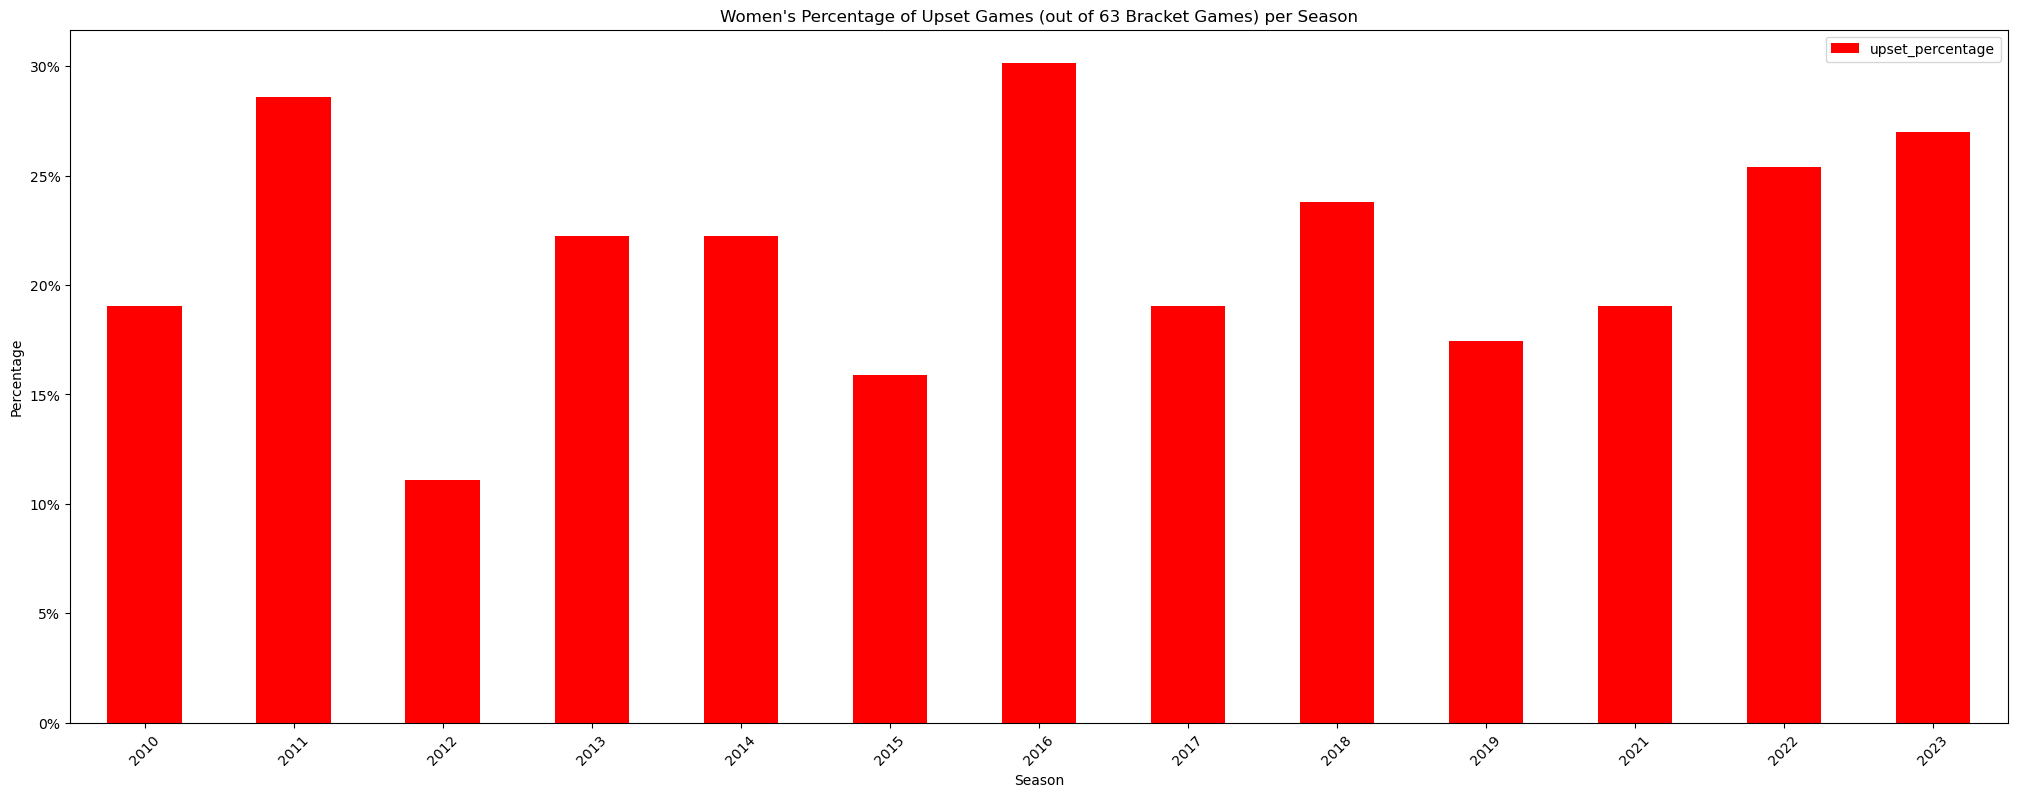

In [33]:
# plot men's percentage of upsets per season
wupset_percentage = (wupsets.groupby('Season').count() / df_womens.groupby('Season').count()).rename(columns={'LRegionSeed': 'upset_percentage'}) \
    .reset_index()[['Season', 'upset_percentage']]
ax = wupset_percentage.plot(kind='bar', figsize=(25, 9), x='Season',y='upset_percentage', title='Women\'s Percentage of Upset Games (out of 63 Bracket Games) per Season', 
                            ylabel='Percentage', xlabel='Season', color='red', rot=45)
ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])
plt.show()

In [34]:
# women's
wupset_percentage[['upset_percentage']].describe().T

,count,mean,std,min,25%,50%,75%,max
upset_percentage,13.0,0.216117,0.054038,0.111111,0.190476,0.222222,0.253968,0.301587


#### Round-by-Round Upsets in Women's Bracket

In [35]:
print('WOMEN\'S BRACKET:\n')

# look at upset % per round
for round in list(range(1,7)):
    print(f'Round {round} Upset %: {wupsets[wupsets["round"] == round].shape[0] / df_womens[df_womens["round"] == round].shape[0] * 100:.1f}% \
          ({wupsets[wupsets["round"] == round].shape[0]}/{df_womens[df_womens["round"] == round].shape[0]}) games \
          Avg Seed Diff: {wupsets[wupsets["round"] == round]["Wseed_diff"].mean():.2f}')

WOMEN'S BRACKET:

Round 1 Upset %: 18.0%           (75/416) games           Avg Seed Diff: -3.64
Round 2 Upset %: 27.4%           (57/208) games           Avg Seed Diff: -4.04
Round 3 Upset %: 23.1%           (24/104) games           Avg Seed Diff: -3.21
Round 4 Upset %: 23.1%           (12/52) games           Avg Seed Diff: -1.42
Round 5 Upset %: 30.8%           (8/26) games           Avg Seed Diff: -1.50
Round 6 Upset %: 7.7%           (1/13) games           Avg Seed Diff: -1.00


In [36]:
# create df to hold historical upset data
wupsets_df = pd.DataFrame(columns=['Season', 'Round', 'Pct_upsets', 'Avg_seed_diff', 'Std_seed_diff', 'Avg_seed', 'Std_seed'])

# get upset data for each season and round
for season, group in df_womens.groupby('Season'):
    for round in list(range(1,7)):
        round_group = group[group['round'] == round]

        pct_upsets = group[(group['round'] == round) & (group['Wseed_diff'] < 0)].shape[0] / round_group.shape[0]
        avg_seed_diff = group[(group['round'] == round) & (group['Wseed_diff'] < 0)]['Wseed_diff'].mean()
        std_seed_diff = group[(group['round'] == round) & (group['Wseed_diff'] < 0)]['Wseed_diff'].std()

        # add col for average seed of the teams in that round
        avg_seed = np.mean(round_group['WSeed'].to_list() + round_group['LSeed'].to_list())
        std_seed = np.std(round_group['WSeed'].to_list() + round_group['LSeed'].to_list())

        wupsets_df = pd.concat([wupsets_df, pd.DataFrame([[season, round, pct_upsets, avg_seed_diff, std_seed_diff, avg_seed, std_seed]], columns=wupsets_df.columns)], ignore_index=True)

# fill nulls, check
wupsets_df = wupsets_df.fillna(0)
wupsets_df['Tournament'] = 'W'
wupsets_df.head(6)

,Season,Round,Pct_upsets,Avg_seed_diff,Std_seed_diff,Avg_seed,Std_seed,Tournament
0,2010,1,0.125,-5.000000,1.632993,8.5000,4.609772,W
1,2010,2,0.250,-4.750000,2.872281,5.1250,3.139964,W
2,2010,3,0.375,-2.333333,1.154701,3.6875,2.662676,W
3,2010,4,0.250,-2.000000,0.000000,2.6250,1.111024,W
4,2010,5,0.000,0.000000,0.000000,2.2500,1.299038,W
5,2010,6,0.000,0.000000,0.000000,1.0000,0.000000,W


In [37]:
# save to csv
pd.concat([mupsets_df, wupsets_df]).to_csv('data/processed/upsets.csv', index=False)

In [38]:
# get abs value of seed diff so we can group
df_womens['abs_seed_diff'] = df_womens['Wseed_diff'].abs()

# print win % of each underdog seed diff group
for seed_diff in sorted(df_womens['abs_seed_diff'].unique())[1:]:
    print(f'-{seed_diff} seed diff win %: {df_womens.loc[(df_womens["abs_seed_diff"] == seed_diff) & (df_womens["Wseed_diff"] < 0)].shape[0] / df_womens.loc[df_mens["abs_seed_diff"] == seed_diff].shape[0] * 100:.1f}% \
            ({df_womens.loc[(df_womens["abs_seed_diff"] == seed_diff) & (df_womens["Wseed_diff"] < 0)].shape[0]}/{df_womens.loc[df_womens["abs_seed_diff"] == seed_diff].shape[0]}) games')

-1 seed diff win %: 45.0%             (63/153) games
-2 seed diff win %: 16.7%             (3/14) games
-3 seed diff win %: 40.5%             (45/124) games
-4 seed diff win %: 16.3%             (7/43) games
-5 seed diff win %: 31.0%             (27/88) games
-6 seed diff win %: 0.0%             (0/2) games
-7 seed diff win %: 17.0%             (15/83) games
-8 seed diff win %: 17.4%             (15/75) games
-9 seed diff win %: 3.4%             (2/61) games
-10 seed diff win %: 0.0%             (0/1) games
-11 seed diff win %: 0.0%             (0/55) games
-13 seed diff win %: 0.0%             (0/52) games
-15 seed diff win %: 0.0%             (0/52) games


- Seed diffs of 2, 4, 6, 8, and 10 have small sample sizes. Seed diffs of 12 and 14 do not exist.
- These specific win %s will be filled in the following section.

In [39]:
# create dict mapping seed diff to win %
seed_diff_win_percentage = {}
for seed_diff in sorted(df_womens['abs_seed_diff'].unique(), reverse=True)[:-1]:
    seed_diff_win_percentage[-seed_diff] = df_womens.loc[(df_womens["abs_seed_diff"] == seed_diff) & (df_womens["Wseed_diff"] < 0)].shape[0] / df_womens.loc[df_mens["abs_seed_diff"] == seed_diff].shape[0]

# equal seeds have 50% win rate
seed_diff_win_percentage[0] = 0.5

# add win probs for seed diffs with little data
for i in [-14, -12, -10, -8, -6, -4, -2]:
    seed_diff_win_percentage[i] = (seed_diff_win_percentage[i-1] + seed_diff_win_percentage[i+1]) / 2

# add positive seed diffs
for i in range(1, 16):
    seed_diff_win_percentage[i] = 1 - seed_diff_win_percentage[-i]

# check
seed_diff_win_percentage.items()

dict_items([(-15, 0.0), (-13, 0.0), (-11, 0.0), (-10, 0.017241379310344827), (-9, 0.034482758620689655), (-8, 0.10246865203761754), (-7, 0.17045454545454544), (-6, 0.2403996865203762), (-5, 0.3103448275862069), (-4, 0.35787511649580617), (-3, 0.40540540540540543), (-2, 0.4277027027027027), (-1, 0.45), (0, 0.5), (-14, 0.0), (-12, 0.0), (1, 0.55), (2, 0.5722972972972973), (3, 0.5945945945945945), (4, 0.6421248835041938), (5, 0.6896551724137931), (6, 0.7596003134796239), (7, 0.8295454545454546), (8, 0.8975313479623824), (9, 0.9655172413793104), (10, 0.9827586206896551), (11, 1.0), (12, 1.0), (13, 1.0), (14, 1.0), (15, 1.0)])

In [40]:
# add win prob col
df_womens['Wseed_win_prob'] = df_womens['Wseed_diff'].apply(lambda x: seed_diff_win_percentage[x])
df_womens['Lseed_win_prob'] = 1 - df_womens['Wseed_win_prob']

# check
df_womens[['Wseed_diff', 'Wseed_win_prob', 'Lseed_win_prob']].head()

,Wseed_diff,Wseed_win_prob,Lseed_win_prob
0,9,0.965517,0.034483
1,1,0.550000,0.450000
2,13,1.000000,0.000000
3,11,1.000000,0.000000
4,7,0.829545,0.170455


## Save Features

In [42]:
# combine df_mens and df_womens
df = pd.concat([df_mens, df_womens], ignore_index=True).reset_index(drop=True)

# save to csv
df.to_csv('data/processed/features_detailed.csv', index=False)